# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [736]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
    min, max, avg, split, round, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType, BooleanType
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [33]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

### Common Functions

In [381]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [583]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
data = data.drop('method')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

data.printSchema()
data.take(3)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', regDate=datetime.datetime(2018, 9, 29, 0, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57), city='Bakersfield', state=' CA'),
 Row(artist='Five Iron Frenzy', auth='Logged In', gender='M', itemInSession=79, length=236.09424, level='free', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', regDate=datetime.datetime(2018, 9, 30, 20, 20, 30), tsDate=datetime.datetime(2018, 10, 1, 2, 3), city='Boston-Cambridge-Newton', state=' MA-NH'),
 Row(artist='Adam Lambert', auth='Logged In', gender

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### EDA on churned users

In [584]:
cols = ['tsDate', 'auth', 'level', 'page', 'status', 'song', 'artist', 'length', 'Churn']

In [640]:
# Count churned users using Cancellation Confirmation evet
data.where(data.page == 'Cancellation Confirmation').dropDuplicates().count()

52

In [597]:
# Label churned users

# extract churned users
churned = data.where(data.page.isin(['Cancellation Confirmation'])) \
    .dropDuplicates() \
    .select('userId') \
    .collect()

# add new column using churned list
churned_uids = [x.userId for x in churned];
is_churn = udf(lambda x: x in churned_uids, BooleanType())
data = data.withColumn('churn', is_churn('userId'))
data.take(3)

# check
data.where(data.churn == True).select('userId').dropDuplicates().count()

52

In [742]:
data.where(data.gender == 'M').count()

123576

In [792]:
# Churn vs Gender

def calc(row):
    if row['gender'] == 'M':
        return row['count']/row['M_total']
    else:
        return row['count']/row['F_total']

# prepare data
df = data \
    .groupby('gender', 'churn') \
    .count() \
    .withColumn('M_total', lit(data.where(data.gender == 'M').count())) \
    .withColumn('F_total', lit(data.where(data.gender == 'F').count())) \
    .toPandas()

df['churn_share'] = df.apply(lambda row: calc(row), axis=1)
df1 = df[df.gender == 'M'].sort_values(by='churn')['total']
df2 = df[df.gender == 'F'].sort_values(by='churn')['total']

# plot
plt.figure(figsize = [6, 6])
width =0.4
labels = ['Non-churned', 'Churned']
plt.xticks(range(2), labels)
plt.xlabel('Gender')
plt.ylabel('Churn')
plt.bar(np.arange(len(df1)), df1, width=width)
plt.bar(np.arange(len(df2))+ width, df2, width=width)
ax = plt.gca()
ax.set_title('Churn vs Gender');
plt.legend(['Male', 'Female'], loc=1)
plt.show()

KeyError: 'total'

In [767]:
df1

churn
False    0.792063
True     0.207937
Name: churn, dtype: float64

In [768]:
df2

churn
False    0.875998
True     0.124002
Name: churn, dtype: float64

In [779]:
df[df.gender == 'M'][['churn', 'churn_share']].set_index('churn')

,churn_share
churn,
True,0.207937
False,0.792063


In [782]:
df[df.gender == 'M'][['churn', 'churn_share']].set_index('churn')[]

,churn_share
churn,
True,0.207937
False,0.792063


In [790]:
df[df.gender == 'M'].sort_values(by='churn')['total']

3    0.792063
0    0.207937
Name: total, dtype: float64

In [786]:
df[df.gender == 'M'].sort_values()

['total'].sort_values()

0    0.207937
3    0.792063
Name: total, dtype: float64

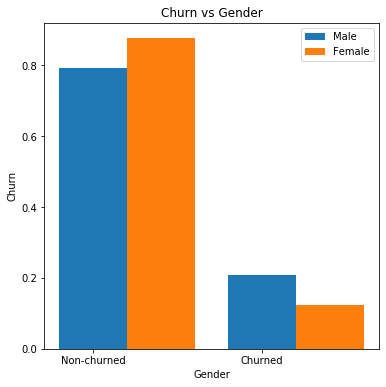

In [791]:
df['total'] = df.apply(lambda row: calc(row), axis=1)
df1 = df[df.gender == 'M'].sort_values(by='churn')['total']
df2 = df[df.gender == 'F'].sort_values(by='churn')['total']

plt.figure(figsize = [6, 6])
width =0.4
labels = ['Non-churned', 'Churned']
plt.xticks(range(2), labels)
plt.xlabel('Gender')
plt.ylabel('Churn')
plt.bar(np.arange(len(df1)), df1, width=width)
plt.bar(np.arange(len(df2))+ width, df2, width=width)
ax = plt.gca()
ax.set_title('Churn vs Gender');
plt.legend(['Male', 'Female'], loc=1)
plt.show()

In [773]:
df = df.drop('total', axis = 1)

In [776]:
def calc(row):
    if row['gender'] == 'M':
        return row['count']/row['M_total']
    else:
        return row['count']/row['F_total']

df['churn_share'] = df.apply(lambda row: calc(row), axis=1)
df 

,gender,churn,count,M_total,F_total,churn_share
0,M,True,25696,123576,154578,0.207937
1,F,False,135410,123576,154578,0.875998
2,F,True,19168,123576,154578,0.124002
3,M,False,97880,123576,154578,0.792063


In [766]:
def calc(row):
    if row['gender'] == 'M':
        return row['count']/row['M_total']
    else:
        return row['count']/row['F_total']

df['total'] = df.apply(lambda row: calc(row), axis=1)
df1 = 

plt.figure(figsize = [6, 6])
width =0.4
labels = ['Non-churned', 'Churned']
plt.xticks(range(2), labels)
plt.xlabel('Gender')
plt.ylabel('Churn')
plt.bar(np.arange(len(df1)), df1, width=width)
plt.bar(np.arange(len(df2))+ width, df2, width=width)
ax = plt.gca()
ax.set_title('Churn vs Gender');
plt.legend(['Male', 'Female'], loc=1)
plt.show()

,gender,churn,count,M_total,F_total,total
0,M,True,25696,123576,154578,0.207937
1,F,False,135410,123576,154578,0.875998
2,F,True,19168,123576,154578,0.124002
3,M,False,97880,123576,154578,0.792063


In [760]:
25696/123576

0.20793681621026736

In [732]:
df = data.groupby('gender', 'churn').count().toPandas()

In [733]:
df

,gender,churn,count
0,M,True,25696
1,F,False,135410
2,F,True,19168
3,M,False,97880


In [729]:
data.groupby('gender').select('churn')

DataFrame[churn: boolean]

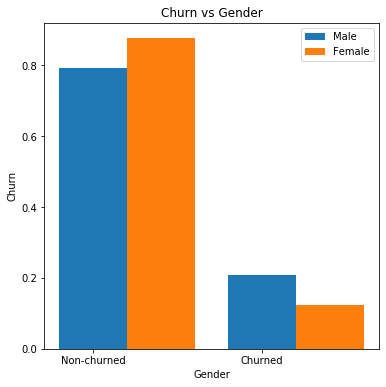

In [726]:
df1 = df[df.gender == 'M'].groupby('churn')['churn'].count()/df[df.gender == 'M']['churn'].count()
df2 = df[df.gender == 'F'].groupby('churn')['churn'].count()/df[df.gender == 'F']['churn'].count()

plt.figure(figsize = [6, 6])
width =0.4
labels = ['Non-churned', 'Churned']
plt.xticks(range(2), labels)
plt.xlabel('Gender')
plt.ylabel('Churn')
plt.bar(np.arange(len(df1)), df1, width=width)
plt.bar(np.arange(len(df2))+ width, df2, width=width)
ax = plt.gca()
ax.set_title('Churn vs Gender');
plt.legend(['Male', 'Female'], loc=1)
plt.show()

In [653]:
df.sort_values(by=['gender','churn']).head()

,gender,churn,count
1,F,False,135410
2,F,True,19168
3,M,False,97880
0,M,True,25696


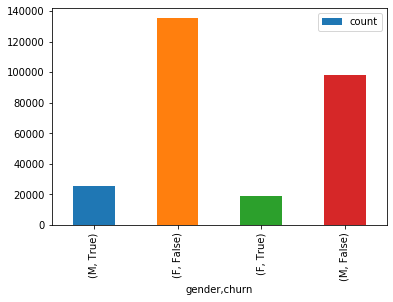

In [649]:
df.plot.bar(y = 'count', x = ['gender','churn']);

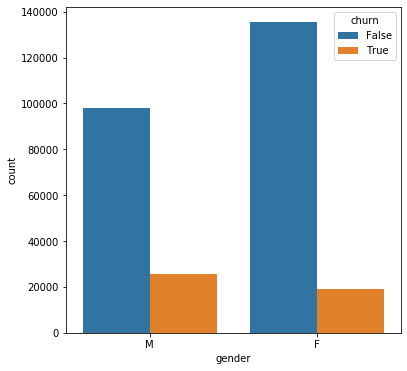

In [670]:
plt.figure(figsize = [6, 6])
df = data.select('gender', 'churn').toPandas()
sb.countplot(data = df, x = 'gender', hue = 'churn');

In [676]:
df.groupby(['gender', 'churn'])['churn'].count()

gender  churn
F       False    135410
        True      19168
M       False     97880
        True      25696
Name: churn, dtype: int64

In [681]:
df[df.gender == 'F']['churn'].count()

154578

In [683]:
df[df.gender == 'F'].groupby('churn')['churn'].count()/df[df.gender == 'F']['churn'].count()

churn
False    0.875998
True     0.124002
Name: churn, dtype: float64

In [684]:
df[df.gender == 'M'].groupby('churn')['churn'].count()/df[df.gender == 'M']['churn'].count()

churn
False    0.792063
True     0.207937
Name: churn, dtype: float64

In [686]:
dt2 = df.groupby(['gender', 'churn']).size().reset_index()
dt2['count'] = dt2.iloc[:, 2]
dt2.drop(0, axis=1, inplace=True)
dt2 = dt2.pivot(index = 'gender', columns = 'churn', values = 'count')
dt2

churn,False,True
gender,,
F,135410,19168
M,97880,25696


(2.0, 0.0)

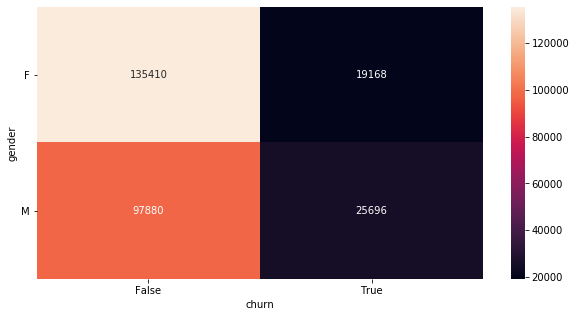

In [687]:
plt.figure(figsize = [10, 5])
ax = sb.heatmap(dt2, annot=True, fmt = '.0f')
plt.yticks(rotation = 0)

# correct plot cut off (Note: we must fix it due to the bug in the matplotlib 3.1.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [630]:
# Are all downgrade events included? - No
data.where((data.churn == False) & (data.page == 'Submit Downgrade')).select('userId').dropDuplicates().count()

40

In [635]:
# Explore non-churned downgrade events
non_churned_downgrade = data.where((data.churn == False) & (data.page == 'Submit Downgrade')).select('userId').dropDuplicates()




In [634]:
non_churned_downgrade \
    .where(col('page')[''])



+------+
|userId|
+------+
|    11|
|    30|
|    59|
|    85|
|    35|
|100008|
|300002|
|    96|
|   100|
|    61|
|   131|
|   140|
|300004|
|300015|
|    77|
|300011|
|100004|
|200003|
|300023|
|100016|
+------+
only showing top 20 rows



In [609]:
data.where((data.churn == False) & (data.page == 'Submit Downgrade')) \
    .groupby('sessionId').count().sort(desc('count')).show()

+---------+-----+
|sessionId|count|
+---------+-----+
|     1695|    2|
|       69|    2|
|      249|    1|
|      487|    1|
|      532|    1|
|      734|    1|
|     2041|    1|
|      144|    1|
|      378|    1|
|      190|    1|
|      459|    1|
|     1689|    1|
|     1918|    1|
|       28|    1|
|     1875|    1|
|      115|    1|
|       67|    1|
|      132|    1|
|      529|    1|
|      202|    1|
+---------+-----+
only showing top 20 rows



In [459]:
# Count churned users - must fulfill te following 2 conditions:
#   1. User must interact with 'Submit Downgrade' page OR 'Cancellation Confirmation' page
#   

users = data \
    .where(data.page.isin(['Submit Downgrade', 'Cancellation Confirmation']) & (data.level == 'paid')) \
    .groupby('userId') \
    .agg(min('ts').alias('timestamp_min'), max('ts').alias('timestamp_max')) \
    .collect()

# list of userIds
uids = [x.userId for x in users];

is_candidate = udf(lambda x: x.isin(uids))


In [463]:
cols = ['userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status']
data.where(data.userId.isin(uids)) \
    .groupby('userId') \
    .count() \
    .sort('count') \
    .show()
    #.select(cols).show(500)

+------+-----+
|userId|count|
+------+-----+
|   122|   62|
|    32|  108|
|300007|  143|
|     3|  254|
|300004|  262|
|100014|  310|
|   129|  412|
|    73|  457|
|100023|  494|
|    18|  513|
|100007|  520|
|200024|  552|
|100012|  600|
|200017|  620|
|100025|  623|
|    24|  630|
|100016|  638|
|200019|  639|
|100009|  671|
|    11|  848|
+------+-----+
only showing top 20 rows



In [465]:
cols = ['userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status']
data.where(data.userId == 122).select(cols).show(500)

+------+-------------------+---------+-------------------+---------+-----+--------------------+------+
|userId|            regDate|sessionId|             tsDate|     auth|level|                page|status|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+
|   122|2018-08-29 01:25:05|      403|2018-10-04 14:47:15|Logged In| free|                Home|   200|
|   122|2018-08-29 01:25:05|      403|2018-10-04 14:47:16|Logged In| free|              Logout|   307|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:12:18|Logged In| free|                Home|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:14:24|Logged In| free|            NextSong|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:17:04|Logged In| free|            NextSong|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:19:15|Logged In| free|            NextSong|   200|
|   122|2018-08-29 01:25:05|      611|2018-10-10 14:24:24|Logged In| free

In [ ]:
# get last log
cols = ['userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status']
data.where(data.userId.isin(uids)) \
    .groupby('userId') \
    .agg(max())
    .show()
    #.select(cols).show(500)

In [487]:
from pyspark.sql.window import Window

w =  Window.partitionBy(data.userId).orderBy(col('ts').desc())

In [496]:
from pyspark.sql.functions import row_number

data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))

In [505]:
data2.where((data2.rown == 1) \
            & (data2.level == 'free') \
            & (data2.userId.isin(uids))).show()

+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|userId|            regDate|sessionId|             tsDate|     auth|level|                page|status|rown|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|    35|2018-09-16 01:16:52|     2354|2018-11-30 11:24:09|Logged In| free|         Roll Advert|   200|   1|
|100008|2018-09-20 12:44:31|      201|2018-11-27 17:13:39|Logged In| free|              Logout|   307|   1|
|100025|2018-07-26 19:19:29|      129|2018-10-23 14:52:32|Cancelled| free|Cancellation Conf...|   200|   1|
|    61|2018-09-17 14:48:58|     2345|2018-11-28 18:54:04|Logged In| free|                Home|   200|   1|
|   131|2018-08-01 07:45:30|     2281|2018-11-30 04:21:23|Logged In| free|                Home|   200|   1|
|300004|2018-08-17 15:44:05|      267|2018-11-14 23:41:25|Logged In| free|           Thumbs Up|   307|   1|
|100009|2018-09-19 19:00:37|

In [514]:
data2.where((data2.rown == 1) & (data2.userId == 122)).show(500)

+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|userId|            regDate|sessionId|             tsDate|     auth|level|                page|status|rown|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+
|   122|2018-08-29 01:25:05|     1029|2018-10-20 21:01:08|Cancelled| paid|Cancellation Conf...|   200|   1|
+------+-------------------+---------+-------------------+---------+-----+--------------------+------+----+



In [530]:
# GET CHURNED USERS
users = data \
    .where(data.page.isin(['Submit Downgrade', 'Cancellation Confirmation'])) \
    .select('userId') \
    .dropDuplicates() \
    .collect()

# list of userIds
uids = [x.userId for x in users];

# Window
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc())
data2 = data.select('userId', 'regDate', 'sessionId', 'tsDate', 'auth', 'level', 'page', 'status',
        row_number().over(w).alias("rown"))
    
# final query
data2 \
    .where(data2.rown == 1) \
    .where(data2.userId.isin(uids)) \
    .where((data2.level == 'free') | (data2.page == 'Cancellation Confirmation')) \
    .count()



67

In [ ]:
overUser = window.partitionBy('userId')
w = data.withColumn(
  "rown", array_contains('userId', 'tsDate', 'auth', 'level', 'page', 'status') over overUser).withColumn(
  "total_salary_in_dep", sum('salary) over overCategory)
df.show()

In [ ]:
to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0), TimestampType())
data = data.withColumn('tsDate', to_date('ts'))
data = data.withColumn('regDate', to_date('registration'))



In [440]:
users[0]

Row(userId='125', timestamp_min=1539318918000, timestamp_max=1539318918000)

In [ ]:
df = data.groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('sessionId', round(col('duration'), 1).alias('duration')) \
    .toPandas()

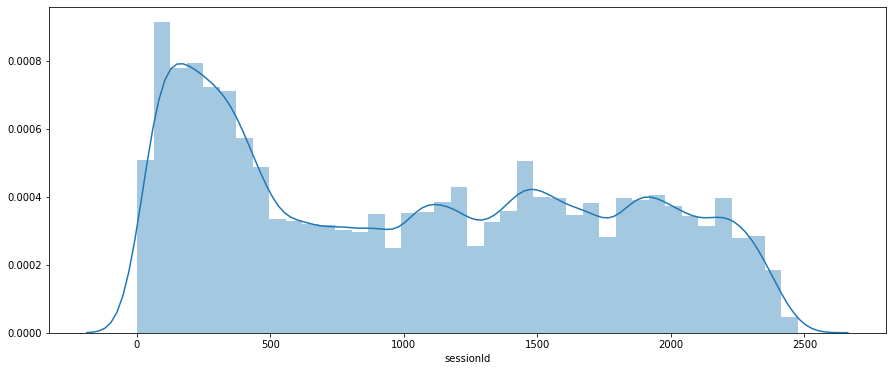

In [41]:
plt.figure(figsize=(15,6))
sb.distplot(df['sessionId'], bins=40)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.